---
title: Linear Regression and Uncertainty Quantification
---

In [42]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt

## Dataset One: US Population

    observation_date  POPTHM
0         1959-01-01  175818
1         1959-02-01  176044
2         1959-03-01  176274
3         1959-04-01  176503
4         1959-05-01  176723
..               ...     ...
794       2025-03-01  341729
795       2025-04-01  341874
796       2025-05-01  342032
797       2025-06-01  342197
798       2025-07-01  342370

[799 rows x 2 columns]


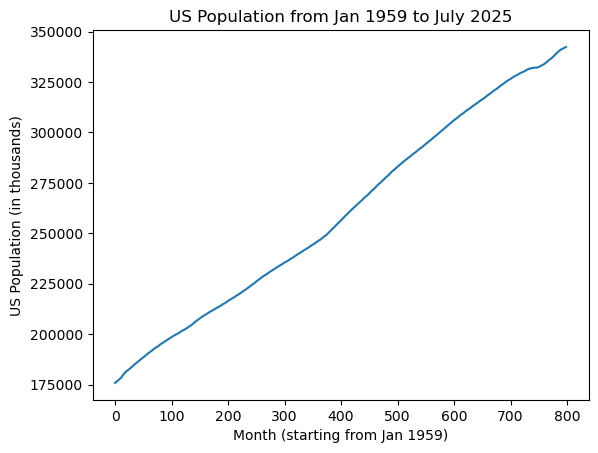

In [43]:
uspop = pd.read_csv("POPTHM_01September2025.csv")
print(uspop)
y = uspop['POPTHM']
n = len(y)
plt.plot(y)
plt.xlabel('Month (starting from Jan 1959)')
plt.ylabel('US Population (in thousands)')
plt.title('US Population from Jan 1959 to July 2025')
plt.show()

Let us fit the simple linear regression model to this data (with time as covariate). 

In [44]:
X = np.column_stack([np.ones(n), np.arange(1, n+1)])
linmod = sm.OLS(y, X).fit()
print(linmod.summary())

                            OLS Regression Results                            
Dep. Variable:                 POPTHM   R-squared:                       0.997
Model:                            OLS   Adj. R-squared:                  0.997
Method:                 Least Squares   F-statistic:                 2.740e+05
Date:                Tue, 09 Sep 2025   Prob (F-statistic):               0.00
Time:                        16:51:18   Log-Likelihood:                -7434.1
No. Observations:                 799   AIC:                         1.487e+04
Df Residuals:                     797   BIC:                         1.488e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.745e+05    188.487    925.579      0.0

The fitted regression line is plotted below along with the observed data. 

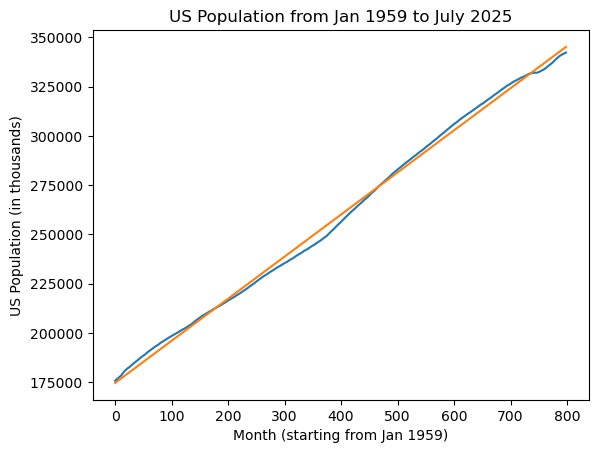

In [45]:
import matplotlib.pyplot as plt
plt.plot(y)
plt.plot(linmod.fittedvalues)
plt.xlabel('Month (starting from Jan 1959)')
plt.ylabel('US Population (in thousands)')
plt.title('US Population from Jan 1959 to July 2025')
plt.show()

We have seen that the posterior distribution of $\beta_0, \dots, \beta_m$ is given by: 
\begin{align*}
   \beta_0, \dots, \beta_m \mid \text{data} \sim t_{m+1} \left(\hat{\beta}, \frac{S(\hat{\beta})}{n-m-1} (X^T X)^{-1}, n-m-1 \right)
\end{align*}
We can generate samples from this posterior distribution and plot the resulting lines on the observed data. This will give us an idea of the uncertainty in the parameters.

In [46]:
#First we compute betahat:
betahat = linmod.params
print(betahat)
#Next we compute S(betahat):
S_betahat = np.sum(linmod.resid ** 2)
print(S_betahat)
#Next Sigma = S_betahat / (n - m - 1) * (X^T X)^{-1}:
m = X.shape[1] - 1 #in this case, m = 1
n = len(y)
Sigma = S_betahat / (n - m - 1) * np.linalg.inv(X.T @ X)
print(Sigma)

const    174459.566196
x1          213.684996
dtype: float64
5645370656.649733
[[ 3.55273594e+04 -6.66554585e+01]
 [-6.66554585e+01  1.66638646e-01]]


This matrix $\frac{S(\hat{\beta})}{n-m-1} (X^T X)^{-1}$ is actually calculated as part of the sm.OLS output, and can be obtained as follows:

In [47]:
print(linmod.cov_params()) #this coincides with Sigma calculated above. Check out help(linmod.cov_params) for more details.
print(Sigma)

              const         x1
const  35527.359360 -66.655458
x1       -66.655458   0.166639
[[ 3.55273594e+04 -6.66554585e+01]
 [-6.66554585e+01  1.66638646e-01]]


Now we need to generate observations from the $t$-distribution. For this, we shall use an inbuilt function from scipy:

In [48]:
from scipy.stats import multivariate_t
N = 1000 #number of samples to generate
beta_samples = multivariate_t.rvs(loc=betahat, shape=Sigma, df=n - m - 1, size=N)
print(beta_samples)

[[174575.00246433    213.39051485]
 [174508.28682041    213.59172482]
 [174109.0428557     214.55694998]
 ...
 [174248.6028745     213.98321738]
 [174411.00997082    213.71640042]
 [174507.67966125    213.30575799]]


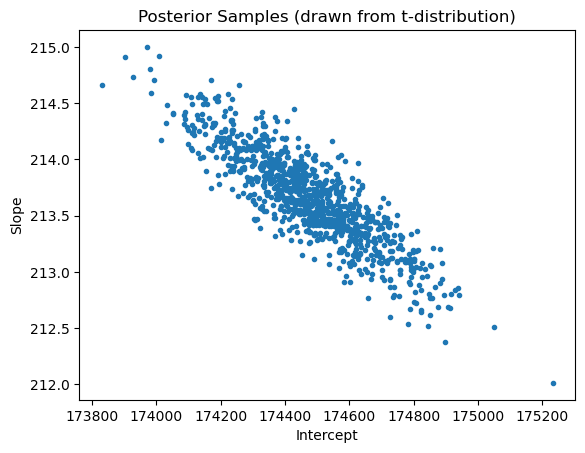

In [49]:
import matplotlib.pyplot as plt
plt.scatter(beta_samples[:,0], beta_samples[:,1], marker = '.')
plt.xlabel('Intercept')
plt.ylabel('Slope')
plt.title('Posterior Samples (drawn from t-distribution)')
plt.show()

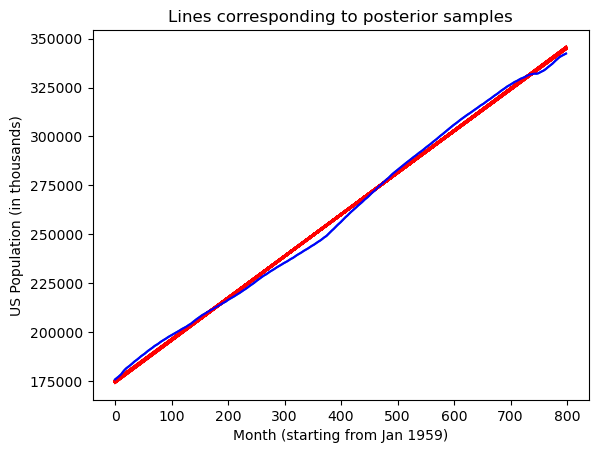

In [50]:
plt.plot(y)
for r in range(N):
    fvalsnew = np.dot(X, beta_samples[r])
    plt.plot(fvalsnew,  color = 'red')
plt.plot(y, color = 'blue')
plt.xlabel('Month (starting from Jan 1959)')
plt.ylabel('US Population (in thousands)')
plt.title('Lines corresponding to posterior samples')
plt.show()

## Dataset Two: Lake Huron Levels

    Unnamed: 0       x
0            1  580.38
1            2  581.86
2            3  580.97
3            4  580.80
4            5  579.79
..         ...     ...
93          94  578.52
94          95  579.74
95          96  579.31
96          97  579.89
97          98  579.96

[98 rows x 2 columns]


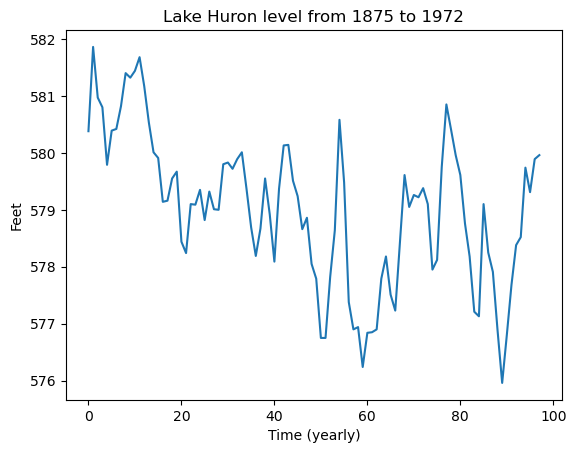

In [51]:
#Lake Huron dataset which gives annual measurements of the level (in feet) of Lake Huron from 1875 to 1972 
huron = pd.read_csv("LakeHuron.csv")
print(huron)
plt.plot(huron['x'])
plt.xlabel('Time (yearly)')
plt.ylabel('Feet')
plt.title('Lake Huron level from 1875 to 1972')
plt.show()

In [52]:
y = huron['x']
n = len(y)
x = np.arange(1, n+1)
X = np.column_stack([np.ones(n), x])
print(X)

[[ 1.  1.]
 [ 1.  2.]
 [ 1.  3.]
 [ 1.  4.]
 [ 1.  5.]
 [ 1.  6.]
 [ 1.  7.]
 [ 1.  8.]
 [ 1.  9.]
 [ 1. 10.]
 [ 1. 11.]
 [ 1. 12.]
 [ 1. 13.]
 [ 1. 14.]
 [ 1. 15.]
 [ 1. 16.]
 [ 1. 17.]
 [ 1. 18.]
 [ 1. 19.]
 [ 1. 20.]
 [ 1. 21.]
 [ 1. 22.]
 [ 1. 23.]
 [ 1. 24.]
 [ 1. 25.]
 [ 1. 26.]
 [ 1. 27.]
 [ 1. 28.]
 [ 1. 29.]
 [ 1. 30.]
 [ 1. 31.]
 [ 1. 32.]
 [ 1. 33.]
 [ 1. 34.]
 [ 1. 35.]
 [ 1. 36.]
 [ 1. 37.]
 [ 1. 38.]
 [ 1. 39.]
 [ 1. 40.]
 [ 1. 41.]
 [ 1. 42.]
 [ 1. 43.]
 [ 1. 44.]
 [ 1. 45.]
 [ 1. 46.]
 [ 1. 47.]
 [ 1. 48.]
 [ 1. 49.]
 [ 1. 50.]
 [ 1. 51.]
 [ 1. 52.]
 [ 1. 53.]
 [ 1. 54.]
 [ 1. 55.]
 [ 1. 56.]
 [ 1. 57.]
 [ 1. 58.]
 [ 1. 59.]
 [ 1. 60.]
 [ 1. 61.]
 [ 1. 62.]
 [ 1. 63.]
 [ 1. 64.]
 [ 1. 65.]
 [ 1. 66.]
 [ 1. 67.]
 [ 1. 68.]
 [ 1. 69.]
 [ 1. 70.]
 [ 1. 71.]
 [ 1. 72.]
 [ 1. 73.]
 [ 1. 74.]
 [ 1. 75.]
 [ 1. 76.]
 [ 1. 77.]
 [ 1. 78.]
 [ 1. 79.]
 [ 1. 80.]
 [ 1. 81.]
 [ 1. 82.]
 [ 1. 83.]
 [ 1. 84.]
 [ 1. 85.]
 [ 1. 86.]
 [ 1. 87.]
 [ 1. 88.]
 [ 1. 89.]
 [ 1. 90.]
 [ 1. 91.]

In [53]:
linmod = sm.OLS(y, X).fit()
print(linmod.summary())

                            OLS Regression Results                            
Dep. Variable:                      x   R-squared:                       0.272
Model:                            OLS   Adj. R-squared:                  0.265
Method:                 Least Squares   F-statistic:                     35.95
Date:                Tue, 09 Sep 2025   Prob (F-statistic):           3.55e-08
Time:                        16:55:48   Log-Likelihood:                -150.05
No. Observations:                  98   AIC:                             304.1
Df Residuals:                      96   BIC:                             309.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        580.2020      0.230   2521.398      0.0

In [54]:
N = 1000 #number of samples to generate
n = X.shape[0]
m = X.shape[1] - 1
beta_samples = multivariate_t.rvs(loc=linmod.params, shape=linmod.cov_params(), df=n - m - 1, size=N)
print(beta_samples)

[[ 5.80499273e+02 -2.78497563e-02]
 [ 5.80376544e+02 -2.50568409e-02]
 [ 5.80254458e+02 -2.53452978e-02]
 ...
 [ 5.80128367e+02 -2.27296382e-02]
 [ 5.80430828e+02 -2.74647190e-02]
 [ 5.80262300e+02 -2.75464709e-02]]


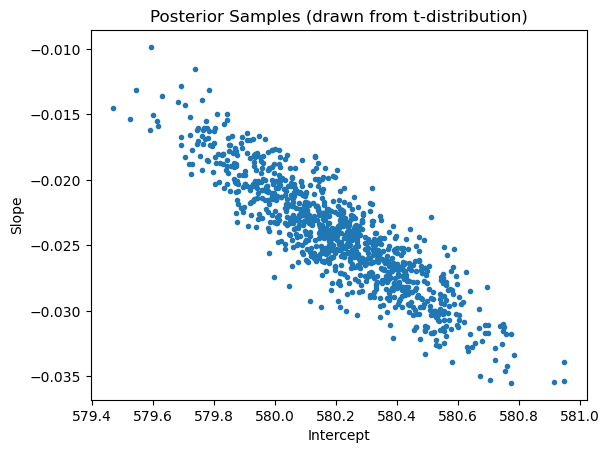

In [55]:
import matplotlib.pyplot as plt
plt.scatter(beta_samples[:,0], beta_samples[:,1], marker = '.')
plt.xlabel('Intercept')
plt.ylabel('Slope')
plt.title('Posterior Samples (drawn from t-distribution)')
plt.show()

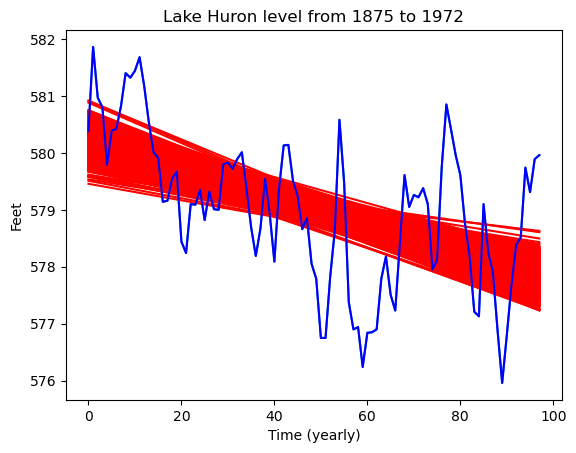

In [56]:
plt.plot(y)
for r in range(N):
    fvalsnew = np.dot(X, beta_samples[r])
    plt.plot(fvalsnew,  color = 'red')
plt.plot(y, color = 'blue')
plt.xlabel('Time (yearly)')
plt.ylabel('Feet')
plt.title('Lake Huron level from 1875 to 1972')
plt.show()

## Dataset Three: A Simulated Dataset

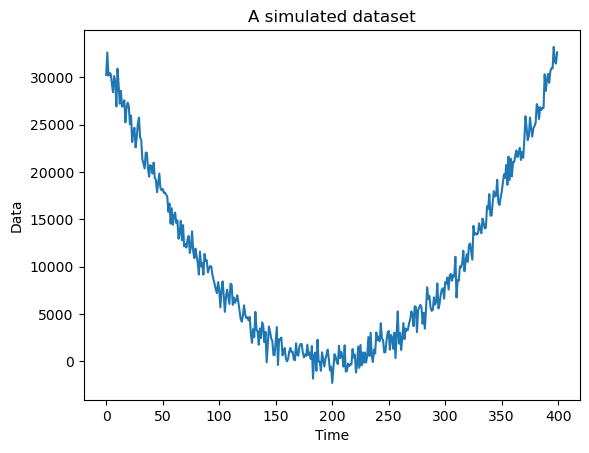

In [57]:
#A simulated dataset
n = 400
x = np.arange(1, n+1)
sig = 1000
rng = np.random.default_rng(12345)
#quadratic data with noise
y = 5 + 0.8 * ((x - (n/2)) ** 2) + rng.normal(loc = 0, scale = sig, size = n)
plt.plot(y) 
plt.xlabel("Time")
plt.ylabel("Data")
plt.title("A simulated dataset")
plt.show()

Let us fit a line (not a quadratic) to this dataset. 

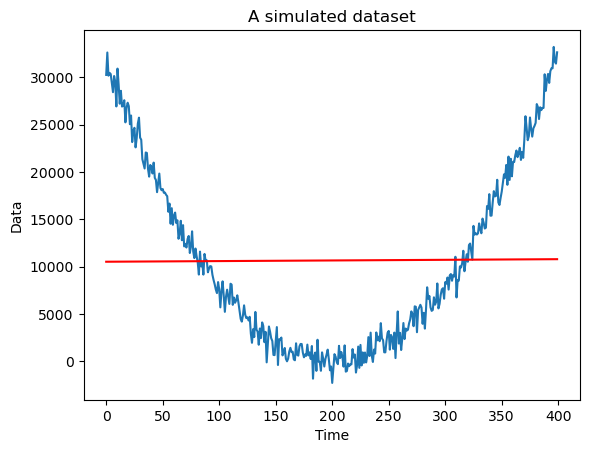

In [58]:
X = np.column_stack([np.ones(n), x])
linmod = sm.OLS(y, X).fit()
plt.plot(y)
plt.plot(linmod.fittedvalues, color = "red")
plt.xlabel("Time")
plt.ylabel("Data")
plt.title("A simulated dataset")
plt.show()

[[ 9.66930939e+03  6.35948185e-01]
 [ 9.82173879e+03  4.95083835e+00]
 [ 1.07166131e+04 -2.58237495e+00]
 ...
 [ 1.11091843e+04 -2.96914690e+00]
 [ 1.17110546e+04 -2.56353648e+00]
 [ 1.08299014e+04  1.92028758e+00]]


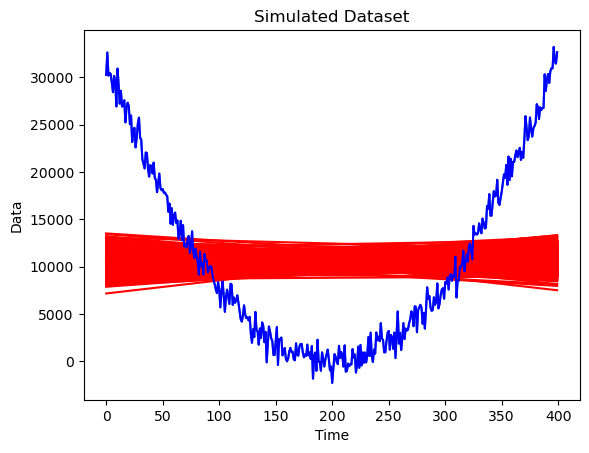

In [59]:
N = 1000 #number of samples to generate
n = X.shape[0]
m = X.shape[1] - 1
beta_samples = multivariate_t.rvs(loc=linmod.params, shape=linmod.cov_params(), df=n - m - 1, size=N)
print(beta_samples)
plt.plot(y)
for r in range(N):
    fvalsnew = np.dot(X, beta_samples[r])
    plt.plot(fvalsnew,  color = 'red')
plt.plot(y, color = 'blue')
plt.xlabel('Time')
plt.ylabel('Data')
plt.title('Simulated Dataset')
plt.show()

The correct thing here is to fit a quadratic. This is done by multiple linear regression as shown below. 

In [60]:
X  = np.column_stack([np.ones(n), x, x ** 2])
quadmod = sm.OLS(y, X).fit()
print(quadmod.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.989
Model:                            OLS   Adj. R-squared:                  0.989
Method:                 Least Squares   F-statistic:                 1.849e+04
Date:                Tue, 09 Sep 2025   Prob (F-statistic):               0.00
Time:                        16:58:01   Log-Likelihood:                -3325.9
No. Observations:                 400   AIC:                             6658.
Df Residuals:                     397   BIC:                             6670.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         3.2e+04    149.517    214.033      0.0

[[ 3.21069430e+04 -3.22423230e+02  8.05609683e-01]
 [ 3.16930896e+04 -3.16670879e+02  7.94291883e-01]
 [ 3.19318577e+04 -3.19033173e+02  7.96698822e-01]
 ...
 [ 3.20219463e+04 -3.19719476e+02  7.98186797e-01]
 [ 3.15799399e+04 -3.15402767e+02  7.89790348e-01]
 [ 3.19058432e+04 -3.19227293e+02  7.98035112e-01]]


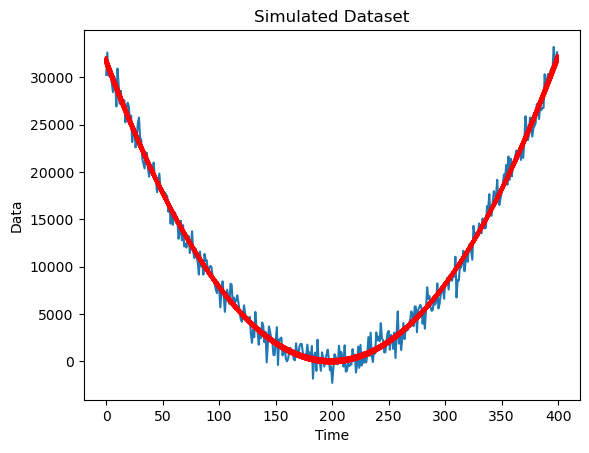

In [61]:
N = 1000 #number of samples to generate
n = X.shape[0]
m = X.shape[1] - 1
beta_samples = multivariate_t.rvs(loc=quadmod.params, shape=quadmod.cov_params(), df=n - m - 1, size=N)
print(beta_samples)
plt.plot(y)
for r in range(N):
    fvalsnew = np.dot(X, beta_samples[r])
    plt.plot(fvalsnew,  color = 'red')
#plt.plot(y, color = 'blue')
plt.xlabel('Time')
plt.ylabel('Data')
plt.title('Simulated Dataset')
plt.show()